# case 2

lid driven cavity

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.scipy.sparse.linalg import cg
from jax.scipy.ndimage import map_coordinates
from typing import NamedTuple
import matplotlib.pyplot as plt

In [2]:
class FluidConfig:
    N_x = 128            #  (N x N)
    N_y = 128
    Lx = 1.0       # spactial scale
    Ly = 1.0
    dx = Lx / N_x
    dy = Ly / N_y

    DT = 0.01 # 0.001          # time step
    VISCOSITY = 0.001   # Diffusion strength
    DIFFUSION_ITER = 20 # CG step for diffusion
    PRESSURE_ITER = 50  # CG step for pressure

    LID_V = 1.0   # lid moving velocity

class FluidState(NamedTuple): # this time scalar density is nolonger needed
    u: jnp.ndarray     
    v: jnp.ndarray

In [3]:
def extend_velocity(f, top, bottom, left, right):
    '''
    extend the velocity field with ghost points

    top, bottom, left, right: the boundary condition values
    e.g., the top lid is moving with the speed 'top'
    '''
    f_extend = jnp.pad(f, ((1,1),(1,1)), mode="constant", constant_values=0.0) # first set extend points to be 0.0

    top_f    = f[-1, :] # take out the values of the unextended field. in order to fill in the extended field
    bottom_f = f[ 0, :]
    left_f   = f[:,  0]
    right_f  = f[:, -1]

    f_extend = f_extend.at[0,  1:-1].set(2.0*bottom-bottom_f) # set the boundary values
    f_extend = f_extend.at[1:-1, 0].set(2.0*left-left_f)
    f_extend = f_extend.at[1:-1,-1].set(2.0*right-right_f)  # corner points are temporally set as the right and top values. will be fixed later
    f_extend = f_extend.at[-1, 1:-1].set(2.0*top - top_f)

    f_extend = f_extend.at[0,0].set(0.5*(f_extend[0,1] + f_extend[1,0])) # set the values of corner points with the average of its two neighbors
    f_extend = f_extend.at[0,-1].set(0.5*(f_extend[0,-2] + f_extend[1,-1]))
    f_extend = f_extend.at[-1,0].set(0.5*(f_extend[-1,1] + f_extend[-2,0]))
    f_extend = f_extend.at[-1,-1].set(0.5*(f_extend[-1,-2] + f_extend[-2,-1]))

    return f_extend

def extend_pressure(p):
    '''
    extend the pressure field.

    for neumann condition, copy the boundary values such that the gradient is zero
    '''
    p_extend = jnp.pad(p, ((1,1),(1,1)), mode="edge") # 'edge' ensure the values are copied
    return p_extend

In [4]:
def extend_u(u):
    '''
    for velocity u in x direction, set top to be lid speed.
    others set to zero, required by no-slip
    '''
    return extend_velocity(u,top=FluidConfig.LID_V, bottom=0.0, left=0.0, right=0.0)

def extend_v(v):
    '''
    all set to be zero, required by no-slip
    '''
    return extend_velocity(v,top=0.0, bottom=0.0, left=0.0, right=0.0)

In [5]:
def laplacian(f_extended, dx,dy):
    '''
    laplacian operator
    
    the input is the extended field.
    remove the outer ghost points and return
    '''
    left  = jnp.roll(f_extended, 1, axis=1)
    right = jnp.roll(f_extended, -1, axis=1)
    down  = jnp.roll(f_extended, 1, axis=0)
    up    = jnp.roll(f_extended, -1, axis=0)
    la_x = (left - 2.0*f_extended + right)/(dx*dx)
    la_y = (up - 2.0*f_extended + down) / (dy*dy)
    la = la_x+la_y
    return la[1:-1, 1:-1] # remove outer points

def divergence(u_extended, v_extended, dx, dy):
    '''
    divergence operator
    
    the input is the extended field.
    remove the outer ghost points and return
    '''
    du_dx = (jnp.roll(u_extended, -1, axis=1) - jnp.roll(u_extended, 1, axis=1)) / (2.0 * dx)
    dv_dy = (jnp.roll(v_extended, -1, axis=0) - jnp.roll(v_extended, 1, axis=0)) / (2.0 * dy)
    return (du_dx + dv_dy)[1:-1, 1:-1]

def gradient(p_extended, dx, dy):
    '''
    gradient operator
    
    the input is the extended field.
    remove the outer ghost points and return
    '''
    dp_dx = (jnp.roll(p_extended, -1, axis=1) - jnp.roll(p_extended, 1, axis=1)) / (2.0 * dx)
    dp_dy = (jnp.roll(p_extended, -1, axis=0) - jnp.roll(p_extended, 1, axis=0)) / (2.0 * dy)
    return dp_dx[1:-1, 1:-1], dp_dy[1:-1, 1:-1]

In [6]:
def advect(f, u, v, dt, dx, dy, extend_fn):
    '''
    first extand the field to be advected
    then follow the same procedure
    '''
    f_extend = extend_fn(f)
    # the difference is that, with the ghost points, coordinates need a  movement: '+1' here
    # this mesh is used to do interpolation. so it is still in the original space
    mesh_y, mesh_x = jnp.meshgrid(jnp.arange(FluidConfig.N_y) + 1.0, jnp.arange(FluidConfig.N_x) + 1.0, indexing='ij')

    # back trace
    mesh_x_new = mesh_x - (u * dt) / dx
    mesh_y_new = mesh_y - (v * dt) / dy

    # and also clip the coordinates to the boundary
    mesh_x_new = jnp.clip(mesh_x_new, 0.0, FluidConfig.N_x + 1.0)
    mesh_y_new = jnp.clip(mesh_y_new, 0.0, FluidConfig.N_y + 1.0)

    coords = jnp.stack([mesh_y_new, mesh_x_new], axis=0)
    return map_coordinates(f_extend, coords, order=1, mode='nearest') # for out-of-domain coords (numerically), set to the value on the boundary
    
def diffuse(f, viscosity, dt, dx, dy, extend_fn):
    '''
    use the extend field to calcuate laplacian， which returns in orignal size. 
    solve CG in the orginal size

    because laplacian is calculated on the extended velocity field, where the moving boundary condition is implemented inside,
    this 'laplacian' operator is will introduce some additional values.
    This value needs to be removed from the diffuse equation.
    '''
    if viscosity == 0:
        return f
    alpha = viscosity * dt

    zeros = jnp.zeros_like(f)  # initialize a zero field
    c = laplacian(extend_fn(zeros), dx, dy) # initialize the additional value introduced by the laplacian operator

    def linear_op(x):
        Lx = laplacian(extend_fn(x), dx, dy)
        return x - alpha * (Lx - c) # removed the additional value from laplacian

    b = f + c * alpha   # to balance the diffuse equation, add this value on the rhs
    f_new, _ = cg(linear_op, b, maxiter=FluidConfig.DIFFUSION_ITER) # solve CG in the orginal size
    return f_new
    
def pressure(rhs, dx, dy):
    '''
    solve the possion equation

    rhs: rhs of the possion equation
    inputs and outputs are all in orignal space.
    '''
    rhs = rhs - rhs.mean()
    p_init = jnp.zeros_like(rhs) # initialize the pressure field with all zeros
    
    def laplacian_op(p):
        return laplacian(extend_pressure(p), dx, dy)
        
    p, _ = cg(laplacian_op, rhs, x0=p_init, maxiter=FluidConfig.PRESSURE_ITER) # CG solve for possion
    p = p - p.mean()
    return p

def project(u, v, dx, dy):
    '''
    projection.
    
    explicitly consider the time step t
    inputs and outputs are all in orignal space.
    '''
    dt= FluidConfig.DT
    u_extend = extend_u(u)
    v_extend = extend_v(v)
    div = divergence(u_extend, v_extend, dx, dy) # divergence of the extended velocity (of the original size)
    p = pressure(div/dt, dx, dy) # solve for the pressure field in the original size
    grad_p_x, grad_p_y = gradient(extend_pressure(p), dx, dy) # extend the pressure field and get gradient. return orginal size
    return u - dt * grad_p_x, v - dt * grad_p_y

In [7]:
@jax.jit
def step_fn(state: FluidState) -> FluidState:
    u, v = state.u, state.v

    # no force
   
    # self-advection
    u_adv = advect(u, u, v, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy, extend_u)
    v_adv = advect(v, u, v, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy, extend_v)
    
    # Diffuse
    u_diff = diffuse(u_adv, FluidConfig.VISCOSITY, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy, extend_u)
    v_diff = diffuse(v_adv, FluidConfig.VISCOSITY, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy, extend_v)
    
    # projection
    u_final, v_final = project(u_diff, v_diff, FluidConfig.dx, FluidConfig.dy)
    
    return FluidState(u_final, v_final)

In [8]:
def init_velocity():
    '''
    initialize an all-zero velocity field
    '''
    u = jnp.zeros((FluidConfig.N_y, FluidConfig.N_x))
    v = jnp.zeros((FluidConfig.N_y, FluidConfig.N_x))
    return FluidState(u, v)

In [9]:
# generate data

In [10]:
state = init_velocity() # initlalize velocity field
_ = step_fn(state) # inital forward function

n_frames = 12 # the 3*4 subplots
steps_per_frame = 150 # steps between different subplots

u_list = [] # use a list to record data
v_list = []

for i in range(n_frames):
    for _ in range(steps_per_frame):
        state = step_fn(state) # forward simulation
        
    
    u = jax.device_get(state.u) # take the data from GPU to CPU
    v = jax.device_get(state.v)
    u_list.append(u) # record data
    v_list.append(v)

In [11]:
# plot

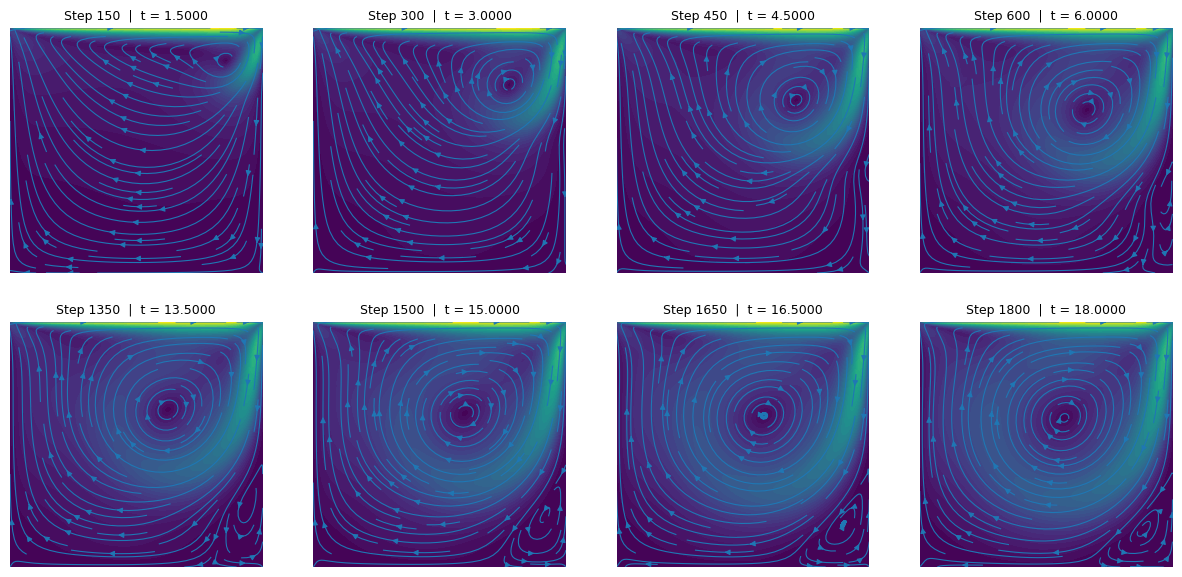

In [12]:
x = np.arange(FluidConfig.N_x) * FluidConfig.dx
y = np.arange(FluidConfig.N_y) * FluidConfig.dy
X, Y = np.meshgrid(x, y) # get the mesh to plot

fig, axes = plt.subplots(2, 4, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    u = u_list[i] # get data from records
    v = v_list[i]

    if i > 3:
        i=i+4 # for the page limitation of PDF, discard the middle row of 3*4 subplot. only get the first and last row
        
    speed = np.sqrt(u*u + v*v)
    ax.contourf(X, Y, speed, levels=50, cmap='viridis')

    ax.streamplot(
        X, Y, u, v,
        density=1.0,
        linewidth=0.8,
        arrowsize=0.8
    ) # plot the stream line
    ax.set_aspect('auto') # streamplot make subplots look irregular

    t = (i+1) * steps_per_frame * FluidConfig.DT
    ax.set_title(f"Step {(i+1) * steps_per_frame}  |  t = {t:.4f}", fontsize=9)
    
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.autoscale(False)
    ax.set_axis_off()
    

fig.set_constrained_layout_pads(
    wspace=0.1,
    hspace=0.1
)

plt.savefig('case_2_lid_driven.png', dpi=300, bbox_inches='tight')
plt.show()


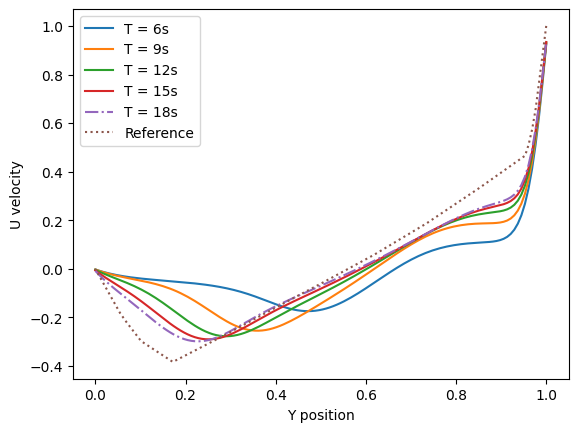

In [13]:
plt.plot(jnp.arange(128)/127, u_list[-9][:,63], label='T = 6s')
plt.plot(jnp.arange(128)/127, u_list[-7][:,63], label='T = 9s')
plt.plot(jnp.arange(128)/127, u_list[-5][:,63], label='T = 12s')
plt.plot(jnp.arange(128)/127, u_list[-3][:,63], label='T = 15s')
plt.plot(jnp.arange(128)/127, u_list[-1][:,63], label='T = 18s', linestyle='-.')
plt.plot([1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000], 
         [1.0, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702, -0.06080, -0.10648, -0.27805,
                            -0.38289, -0.29730, -0.22220, -0.20196, -0.18109, 0.00000],label='Reference', linestyle=':')

plt.xlabel('Y position')
plt.ylabel('U velocity')
plt.legend()
plt.savefig('u_profile_t_120s.png',  dpi=300, bbox_inches='tight')

In [14]:
# use a smaller time step, which satiesfy the CFL condition

In [15]:
FluidState.DT = 0.001 # smaller time step
state = init_velocity()
_ = step_fn(state)

n_frames = 12
steps_per_frame = 1500 # to keep the physical time the same, increase the steps between frames

for i in range(n_frames):
    for _ in range(steps_per_frame):
        state = step_fn(state)
        
u_dt_0p001 = jax.device_get(state.u)

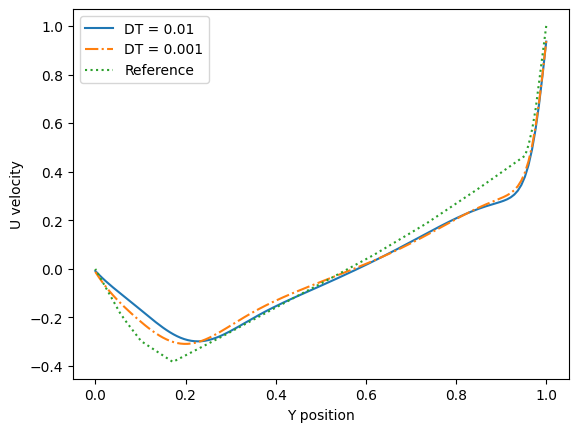

In [16]:
plt.plot(jnp.arange(128)/127, u_list[-1][:,63],label='DT = 0.01')
plt.plot(jnp.arange(128)/127, u_dt_0p001[:,63],label='DT = 0.001', linestyle='-.')
plt.plot([1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000], 
         [1.0, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702, -0.06080, -0.10648, -0.27805,
                            -0.38289, -0.29730, -0.22220, -0.20196, -0.18109, 0.00000],label='Reference', linestyle=':')
plt.xlabel('Y position')
plt.ylabel('U velocity')
plt.legend()
plt.savefig('u_profile.png',  dpi=300, bbox_inches='tight')